In [1]:
# Import necessary libraries
import numpy as np
import sys
import time

from PIL import Image
import PIL

In [2]:
import tensorflow as tf

from tensorflow import keras
# import keras

In [3]:
from keras.layers import Input, InputLayer, Flatten, Activation, Dense, Conv2D

from keras.layers.convolutional import Convolution2D, MaxPooling2D

Using TensorFlow backend.


In [4]:
from keras.activations  import *
from keras.models       import Model, Sequential
from keras.applications import vgg16, imagenet_utils

import keras.backend as K

In [5]:
import math
import matplotlib.pyplot as plt

In [6]:
class DConvolution2D(object):
    
    def __init__(self, layer):

        self.layer = layer

        weights = layer.get_weights()
        W = weights[0]
        b = weights[1]

        filters = W.shape[3]

        up_row = W.shape[0]
        up_col = W.shape[1]
        
        input_img = Input(shape = layer.input_shape[1:])

        output = Conv2D(filters, (up_row, up_col), 
                        kernel_initializer = tf.constant_initializer(W),
                        bias_initializer   = tf.constant_initializer(b),
                        padding='same'
                        )(input_img)
        
        self.up_func = K.function([input_img, K.learning_phase()], [output])
        
        # Deconv filter (exchange no of filters and depth of each filter)
        W = np.transpose(W, (0,1,3,2))
        
        # Reverse columns and rows
        W = W[::-1, ::-1,:,:]
        
        down_filters = W.shape[3]
        down_row = W.shape[0]
        down_col = W.shape[1]
        
        b = np.zeros(down_filters)
        
        input_d = Input(shape = layer.output_shape[1:])

        output = Conv2D(down_filters, (down_row, down_col),
                        kernel_initializer = tf.constant_initializer(W),
                        bias_initializer   = tf.constant_initializer(b),
                        padding = 'same'
                       )(input_d)
        
        self.down_func = K.function([input_d, K.learning_phase()], [output])

    def up(self, data, learning_phase = 0):
        # Forward pass
        self.up_data = self.up_func([data, learning_phase])
        self.up_data = np.squeeze(self.up_data, axis=0)
        self.up_data = np.expand_dims(self.up_data, axis=0)
        
        print('DConvol up_data.shape ' + str(self.up_data.shape))
        return self.up_data

    def down(self, data, learning_phase = 0):
        # Backward pass
        self.down_data = self.down_func([data, learning_phase])
        self.down_data = np.squeeze(self.down_data, axis=0)
        self.down_data = np.expand_dims(self.down_data, axis=0)
        
        print('DConvol dn_data.shape ' + str(self.down_data.shape))
        return self.down_data

In [20]:
class DActivation(object):
    def __init__(self, layer, linear = False):
        
        self.layer = layer
        self.linear = linear
        self.activation = layer.activation
        
        input = K.placeholder(shape = layer.output_shape)

        output = self.activation(input)
        
        # According to the original paper, 
        # In forward pass and backward pass, do the same activation(relu)
        
        # Up method
        self.up_func = K.function([input, K.learning_phase()], [output])
        
        # Down method
        self.down_func = K.function([input, K.learning_phase()], [output])
   
    def up(self, data, learning_phase = 0):
        
        self.up_data = self.up_func([data, learning_phase])
        self.up_data = np.squeeze(self.up_data,axis=0)
        self.up_data = np.expand_dims(self.up_data,axis=0)
        
        print('DActi   up_data.shape ' + str(self.up_data.shape))
        return self.up_data
   
    def down(self, data, learning_phase = 0):
        
        self.down_data = self.down_func([data, learning_phase])

        # print(type(self.down_data))
        # print(self.down_data.shape)
        self.down_data = np.squeeze(self.down_data, axis=0)
        
        # print(type(self.down_data))
        # print(self.down_data.shape)
        self.down_data = np.expand_dims(self.down_data, axis=0)
        # print(self.down_data.shape)
        
        # self.down_data = np.array(self.down_data)
        
        print('DActi   dn_data.shape ' + str(self.down_data.shape))
        return self.down_data

In [8]:
class DInput(object):

    def __init__(self, layer):
        self.layer = layer
    
    # input and output of Inputl layer are the same
    def up(self, data, learning_phase = 0):
        print('')
        self.up_data = data
    
        print('DInput  up_data.shape ' + str(self.up_data.shape))
        print('')
        return self.up_data
    
    def down(self, data, learning_phase = 0):
        print('')
        # data = np.squeeze(data, axis=0)
        data = np.expand_dims(data, axis=0)
        
        self.down_data = data
        
        print('DInput  dn_data.shape ' + str(self.down_data.shape))
        print('')
        return self.down_data

In [9]:
class DDense(object):
  
    def __init__(self, layer):

        self.layer = layer
        
        weights = layer.get_weights()
        W = weights[0]
        b = weights[1]
        
        print('W.shape ' + str(W.shape))
        print('b.shape ' + str(b.shape))
        
        # Up method

        print('dense input shape ' + str(layer.input_shape))
        print('dense ouput shape ' + str(layer.output_shape))
        
        input = Input(shape = layer.input_shape[1:])

        output = Dense( layer.output_shape[1],
                        kernel_initializer = tf.constant_initializer(W),
                        bias_initializer   = tf.constant_initializer(b)
                      )(input)
        
        self.up_func = K.function([input, K.learning_phase()], [output])
        
        # Transpose W for down method
        W = W.transpose()
        self.input_shape = layer.input_shape
        self.output_shape = layer.output_shape
        
        b = np.zeros(self.input_shape[1])
        # flipped_weights = [W, b]
        
        input = Input(shape = self.output_shape[1:])
        
        output = Dense( self.input_shape[1:],
                        kernel_initializer = tf.constant_initializer(W),
                        bias_initializer   = tf.constant_initializer(b)
                      )(input)
        
        self.down_func = K.function([input, K.learning_phase()], [output])

    def up(self, data, learning_phase = 0):
        
        self.up_data = self.up_func([data, learning_phase])
        
        self.up_data = np.squeeze(self.up_data, axis=0)
        self.up_data = np.expand_dims(self.up_data, axis=0)
        
        print('DDense  up_data.shape ' + str(self.up_data.shape))
        return self.up_data
        
    def down(self, data, learning_phase = 0):
    
        self.down_data = self.down_func([data, learning_phase])
        
        self.down_data = np.squeeze(self.down_data, axis=0)
        self.down_data = np.expand_dims(self.down_data, axis=0)
        
        print('DDense  dn_data.shape ' + str(self.down_data.shape))
        return self.down_data

In [10]:
class DFlatten(object):

    def __init__(self, layer):
   
        self.layer = layer
        self.shape = layer.input_shape[1:]
        
        self.up_func = K.function([layer.input, K.learning_phase()], [layer.output])

    # Flatten 2D input into 1D output
    def up(self, data, learning_phase = 0):
        
        self.up_data = self.up_func([data, learning_phase])
        self.up_data = np.squeeze(self.up_data,axis=0)
        self.up_data = np.expand_dims(self.up_data,axis=0)

        print('DFlat   up_data.shape ' + str(self.up_data.shape))
        return self.up_data

    # Reshape 1D input into 2D output
    def down(self, data, learning_phase = 0):

        assert np.prod(self.shape) == np.prod(data.shape[1:])

        new_shape = [data.shape[0]] + list(self.shape)
        self.down_data = np.reshape(data, new_shape)
        
        print('DFlat   dn_data.shape ' + str(self.down_data.shape))
        return self.down_data

In [11]:
class DPooling(object):

    def __init__(self, layer):

        self.layer = layer
        self.poolsize = layer.pool_size
    
    def up(self, data, learning_phase = 0):
        print('')
        [self.up_data, self.switch] = self.__max_pooling_with_switch(data, self.poolsize)
        
        print('DPool   up_data.shape ' + str(self.up_data.shape))
        print('')
        return self.up_data

    def down(self, data, learning_phase = 0):
        print('')
        self.down_data = self.__max_unpooling_with_switch(data, self.switch)
        
        print('DPool   dn_data.shape ' + str(self.down_data.shape))
        print('')
        return self.down_data

    
    def __max_pooling_with_switch(self, input, poolsize):

        switch = np.zeros(input.shape)
        out_shape = list(input.shape)
        
        row_poolsize = int(poolsize[0])
        col_poolsize = int(poolsize[1])
        
        # print('pool row_size ' + str(row_poolsize))
        # print('pool col_size ' + str(col_poolsize))
        print('pool size {} {}'.format(row_poolsize, col_poolsize))
        
        out_shape[1] = math.floor(out_shape[1] / poolsize[0])
        out_shape[2] = math.floor(out_shape[2] / poolsize[1])
        # print('pool outShape ' + str(out_shape))
        
        pooled = np.zeros(out_shape)
        
        for sample in range(input.shape[0]):
            for dim in range(input.shape[3]):
                for row in range(out_shape[1]):
                    for col in range(out_shape[2]):
                        
                        patch = input[sample, 
                                row * row_poolsize : (row + 1) * row_poolsize,
                                col * col_poolsize : (col + 1) * col_poolsize,
                                dim]
                        
                        max_value = patch.max()
                        pooled[sample, row, col,dim] = max_value
                        
                        max_col_index = patch.argmax(axis = 1)
                        max_cols = patch.max(axis = 1)
                        
                        max_row = max_cols.argmax()
                        max_col = max_col_index[max_row]
                        
                        switch[sample, 
                                row * row_poolsize + max_row, 
                                col * col_poolsize + max_col,
                                dim] = 1
                        
        return [pooled, switch]
    
    # Compute unpooled output using pooled data and switch
    def __max_unpooling_with_switch(self, input, switch):

        print('unpool switch ' + str(switch.shape))
        # print('unpool input  ' + str(input.shape))
        
        tile = np.ones((math.floor(switch.shape[1] / input.shape[1]), 
                        math.floor(switch.shape[2] / input.shape[2])))
        
        print('unpool tile   ' + str(tile.shape))
        
        # tile  = np.expand_dims(tile, axis=3)
        tile  = np.expand_dims(tile, axis=2)
        print('unpool expanded tile   ' + str(tile.shape))
        
        input = np.squeeze(input, axis=0)
        print('unpool squeezed input  ' + str(input.shape))
        
        out = np.kron(input, tile)
        print('unpool out    ' + str(out.shape))
        
        unpooled = out * switch
        print('unpool*switch ' + str(unpooled.shape))
        
        unpooled = np.expand_dims(unpooled, axis=0)
        return unpooled

In [12]:
def visualize(model, data, layer_name, feature_to_visualize, visualize_mode):
    
    deconv_layers = []
    
    # Stack layers
    for i in range(len(model.layers)):
        
        if isinstance(model.layers[i], Convolution2D):
            
            deconv_layers.append(DConvolution2D(model.layers[i]))
            deconv_layers.append(DActivation(model.layers[i]))
            
        elif isinstance(model.layers[i], MaxPooling2D):
            
            deconv_layers.append(DPooling(model.layers[i]))
            
        elif isinstance(model.layers[i], Dense):
            
            deconv_layers.append(DDense(model.layers[i]))
            deconv_layers.append(DActivation(model.layers[i]))
            
        elif isinstance(model.layers[i], Activation):
            
            print('independent Activation layer found, what is model.alyers')
            deconv_layers.append(DActivation(model.alyers[i]))
            
        elif isinstance(model.layers[i], Flatten):
            
            deconv_layers.append(DFlatten(model.layers[i]))
            
        elif isinstance(model.layers[i], InputLayer):
            
            deconv_layers.append(DInput(model.layers[i]))
        else:
            print('Cannot handle this type of layer')
            print(model.layers[i].get_config())
            sys.exit()
            
        if layer_name == model.layers[i].name:
            break

    # Forward pass
    deconv_layers[0].up(data)
    
    for i in range(1, len(deconv_layers)):
        deconv_layers[i].up(deconv_layers[i - 1].up_data)

    output = deconv_layers[-1].up_data
    
    print('')
    print('output.shape ' + str(output.shape))
    print('')
    
    assert output.ndim == 2 or output.ndim == 4
    
    if output.ndim == 2:
        feature_map = output[:, feature_to_visualize]
    else:
        feature_map = output[:,:, :, feature_to_visualize]
    
    if 'max' == visualize_mode:
        
        max_activation = feature_map.max()
        temp = feature_map == max_activation
        feature_map = feature_map * temp
        
    elif 'all' != visualize_mode:
        
        print('Illegal visualize mode')
        sys.exit()
    
    output = np.zeros_like(output)
    
    if 2 == output.ndim:
        output[:, feature_to_visualize] = feature_map
    else:
        output[:,: , :, feature_to_visualize] = feature_map

    
    # Backward pass
    deconv_layers[-1].down(output)
    
    for i in range(len(deconv_layers) - 2, -1, -1):
        deconv_layers[i].down(deconv_layers[i + 1].down_data)
    
    deconv = deconv_layers[0].down_data
    deconv = deconv.squeeze()

    return deconv

In [21]:
model = vgg16.VGG16(weights = 'imagenet', include_top = True)

In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [23]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

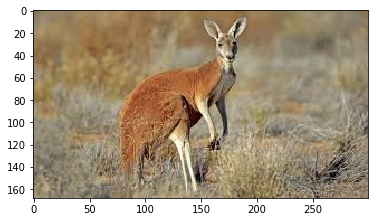

(300, 168)
(224, 224)
(224, 224, 3)


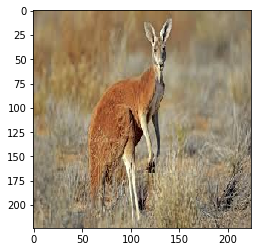

(1, 224, 224, 3)


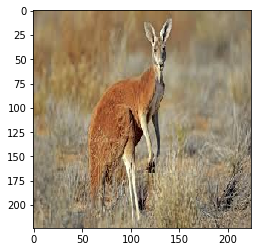

In [24]:
image_path = "Results/Deconvnet/kangaroo.jpg"

# Load data and preprocess
img = Image.open(image_path)
plt.imshow(img)
plt.show()
print(img.size)
img = img.resize((224, 224),resample=PIL.Image.NEAREST)
print(img.size)

img_array = np.array(img)
print(img_array.shape)

plt.imshow(img_array)
plt.show()

img_array = img_array[np.newaxis, :]
print(img_array.shape)

plt.imshow(img_array[0])
plt.show()

W0329 11:23:03.612581  6996 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[130. 113.  87.]
 [129. 112.  84.]
 [129. 112.  84.]
 [132. 115.  87.]
 [140. 123.  93.]
 [143. 126.  96.]
 [144. 127.  97.]
 [146. 130.  97.]
 [148. 132.  99.]
 [149. 133.  99.]
 [152. 136. 102.]
 [153. 137. 104.]
 [149. 133. 108.]
 [150. 132. 108.]
 [150. 133. 107.]
 [150. 133. 107.]
 [152. 133. 103.]
 [152. 133. 103.]
 [155. 136. 106.]
 [154. 133. 106.]
 [153. 132. 105.]
 [153. 128. 106.]
 [150. 125. 105.]
 [148. 126. 103.]
 [149. 129. 104.]
 [149. 130. 100.]
 [149. 130. 100.]
 [151. 130.  99.]
 [153. 130.  98.]
 [153. 131.  94.]
 [161. 137. 101.]
 [164. 139.  99.]
 [164. 139.  98.]
 [167. 140.  97.]
 [170. 141.  97.]
 [170. 141.  97.]
 [167. 138.  96.]
 [165. 137.  98.]
 [165. 137.  98.]
 [165. 136. 102.]
 [162. 136. 103.]
 [162. 136. 103.]
 [161. 137. 103.]
 [162. 138. 102.]
 [163. 139. 101.]
 [163. 141. 102.]
 [165. 144. 101.]
 [166. 145. 100.]
 [173. 150. 106.]
 [168. 144. 100.]
 [165. 141.  97.]
 [163. 139.  93.]
 [167. 140.  95.]
 [168. 141.  96.]
 [164. 137.  90.]
 [168. 140

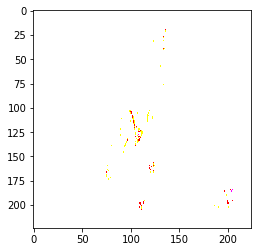

W0329 11:23:03.753561  6996 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[-16.939  -3.779   6.32 ]
 [-19.939  -4.779   5.32 ]
 [-19.939  -4.779   5.32 ]
 [-16.939  -1.779   8.32 ]
 [-10.939   6.221  16.32 ]
 [ -7.939   9.221  19.32 ]
 [ -6.939  10.221  20.32 ]
 [ -6.939  13.221  22.32 ]
 [ -4.939  15.221  24.32 ]
 [ -4.939  16.221  25.32 ]
 [ -1.939  19.221  28.32 ]
 [  0.061  20.221  29.32 ]
 [  4.061  16.221  25.32 ]
 [  4.061  15.221  26.32 ]
 [  3.061  16.221  26.32 ]
 [  3.061  16.221  26.32 ]
 [ -0.939  16.221  28.32 ]
 [ -0.939  16.221  28.32 ]
 [  2.061  19.221  31.32 ]
 [  2.061  16.221  30.32 ]
 [  1.061  15.221  29.32 ]
 [  2.061  11.221  29.32 ]
 [  1.061   8.221  26.32 ]
 [ -0.939   9.221  24.32 ]
 [  0.061  12.221  25.32 ]
 [ -3.939  13.221  25.32 ]
 [ -3.939  13.221  25.32 ]
 [ -4.939  13.221  27.32 ]
 [ -5.939  13.221  29.32 ]
 [ -9.939  14.221  29.32 ]
 [ -2.939  20.221  37.32 ]
 [ -4.939  22.221  40.32 ]
 [ -5.939  22.221  40.32 ]
 [ -6.939  23.221  43.32 ]
 [ -6.939  24.221  46.32 ]
 [ -6.939  24.221  46.32 ]
 [ -7.939  21.221  43.32 ]
 

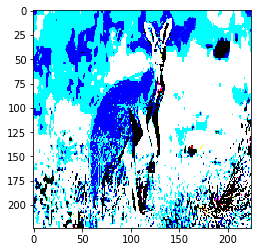

In [25]:
img_array = img_array.astype(np.float)
print(img_array[0][0])
plt.imshow(img_array[0])
plt.show()

img_array = imagenet_utils.preprocess_input(img_array)
print(img_array[0][0])
plt.imshow(img_array[0])
plt.show()

In [38]:
# layer_name = 'block3_conv3'
layer_name = 'block5_pool'
# layer_name = 'predictions'

feature_to_visualize = 511 # 2 # 127

visualize_mode = 'all'

In [39]:
deconv = visualize( model, img_array
                  , layer_name
                  , feature_to_visualize
                  , visualize_mode
                  )


DInput  up_data.shape (1, 224, 224, 3)

DConvol up_data.shape (1, 224, 224, 64)
DActi   up_data.shape (1, 224, 224, 64)
DConvol up_data.shape (1, 224, 224, 64)
DActi   up_data.shape (1, 224, 224, 64)

pool size 2 2
DPool   up_data.shape (1, 112, 112, 64)

DConvol up_data.shape (1, 112, 112, 128)
DActi   up_data.shape (1, 112, 112, 128)
DConvol up_data.shape (1, 112, 112, 128)
DActi   up_data.shape (1, 112, 112, 128)

pool size 2 2
DPool   up_data.shape (1, 56, 56, 128)

DConvol up_data.shape (1, 56, 56, 256)
DActi   up_data.shape (1, 56, 56, 256)
DConvol up_data.shape (1, 56, 56, 256)
DActi   up_data.shape (1, 56, 56, 256)
DConvol up_data.shape (1, 56, 56, 256)
DActi   up_data.shape (1, 56, 56, 256)

pool size 2 2
DPool   up_data.shape (1, 28, 28, 256)

DConvol up_data.shape (1, 28, 28, 512)
DActi   up_data.shape (1, 28, 28, 512)
DConvol up_data.shape (1, 28, 28, 512)
DActi   up_data.shape (1, 28, 28, 512)
DConvol up_data.shape (1, 28, 28, 512)
DActi   up_data.shape (1, 28, 28, 512)



W0329 11:54:01.820127  6996 image.py:656] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


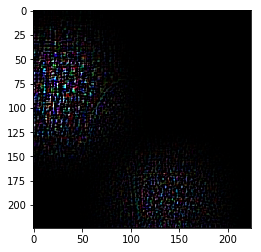

In [40]:
#After deconvolution-
plt.imshow(deconv)
plt.show()

In [41]:
print(deconv.shape)

# postprocess and save image

#deconv = np.transpose(deconv, ())
deconv = deconv - deconv.min()
deconv *= 1.0 / (deconv.max() + 1e-8)
#deconv = deconv[:, :, ::-1]

uint8_deconv = (deconv * 255).astype(np.uint8)

(224, 224, 3)


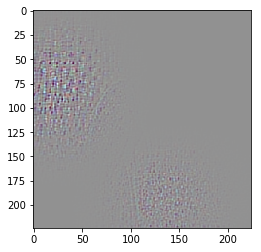

In [42]:
img = Image.fromarray(uint8_deconv, 'RGB')
img.save('Results/Deconvnet/kangaroo{}_{}_{}.png'.
         format(layer_name, feature_to_visualize, visualize_mode))

plt.imshow(img)
plt.show()